# Introduction

In this notebook our primary focus is on forecasting using the SARIMAX model. We have already completed the initial stages of exploratory data analysis, allowing us to transition to the forecasting phase.

We'll employ the SARIMAX model to generate forecasts based on historical data patterns. The SARIMAX model combines autoregressive and moving average components, seasonal effects, and the inclusion of exogenous variables to facilitate accurate time series forecasting. We'll follow a structured approach, including model selection, parameter estimation, and diagnostic assessments to effectively apply SARIMAX modeling for forecasting purposes. Our ultimate objective is to provide you with practical insights and examples that can be readily applied to diverse real-world scenarios, enabling data-driven decision-making and predictive analysis. This hands-on approach will provide valuable insights and real-world examples that can be readily applied to a diverse range of scenarios, enabling data-driven decision-making and predictive analysis within the confines of this single Jupyter notebook.

## The SARIMAX model

The Seasonal Autoregressive Integrated Moving Average with Exogenous Regressors (SARIMAX) model is a powerful time series forecasting technique that extends the traditional ARIMA (Autoregressive Integrated Moving Average) model by incorporating seasonal and exogenous components (external factor that influences the time series data). SARIMAX is designed to model and predict time-dependent data that exhibit both non-seasonal and seasonal patterns, making it highly flexible and widely used in various domains such as finance, economics, and demand forecasting.

### Components of SARIMAX

**Seasonal Component (S):** SARIMAX introduces a seasonal component to account for periodic patterns in the data. This component is denoted by **(P, D, Q, s)**, where:

- **P:** The seasonal autoregressive order represents the number of seasonal lags in the autoregressive part.
- **D:** The seasonal differencing order indicates the number of seasonal differences needed to achieve stationarity.
- **Q:** The seasonal moving average order represents the number of seasonal lags in the moving average part.
- **s:** The seasonal period defines the number of time steps in each seasonal cycle (e.g., 12 for monthly data with an annual seasonality).

**Non-Seasonal Component (p, d, q):** The non-seasonal component of SARIMAX follows the same principles as the traditional ARIMA model:

- **p:** The autoregressive order represents the number of non-seasonal lags in the autoregressive part.
- **d:** The differencing order indicates the number of differences needed to make the data stationary.
- **q:** The moving average order represents the number of non-seasonal lags in the moving average part.

**Exogenous Regressors (X):** SARIMAX allows for the inclusion of exogenous variables that can enhance the model's predictive capability. Exogenous variables are external factors that can influence the time series being forecasted. These variables can be incorporated into the model as additional features to capture their impact on the target variable.

### Modeling and Forecasting Process

The process of building a SARIMAX model begins with identifying the appropriate values of (p, d, q) and (P, D, Q, s). This is typically done by analyzing the autocorrelation and partial autocorrelation plots of the time series data. Autocorrelation (ACF) and partial autocorrelation (PACF) plots are graphical tools used in time series analysis to understand the correlation structure within a dataset. They help identify the appropriate orders (p and q) for the autoregressive (AR) and moving average (MA) components of a time series model, such as the ARIMA or SARIMAX model.

The ACF plot (Figure 1) displays the correlation between a time series and its lagged values, where "lag" refers to the time delay or number of time steps between data points. It helps identify the order of the moving average (MA) component in a time series model. Peaks or significant spikes in the ACF plot indicate the number of lag values to consider for the MA component of the model.

In contrast, the PACF plot (Figure 2) displays the correlation between a time series and its lagged values while removing the effect of shorter lags through partial correlation. It helps identify the order of the autoregressive (AR) component in a time series model. Peaks or significant spikes in the PACF plot indicate the number of lag values to consider for the AR component of the model. The PACF values at lags beyond these significant spikes are assumed to be zero.

<div style="display: flex;">
  <div style="flex: 50%; padding: 10px;">
    <img src="imgs/acf.png" alt="Figure 1">
    <p>Figure 1 - Autocorrelation plot</p>
  </div>
  <div style="flex: 50%; padding: 10px;">
    <img src="imgs/pacf.png" alt="Figure 2">
    <p>Figure 2 - Partial autocorrelation plot</p>
  </div>
</div>


Once the parameters are determined, the SARIMAX model is constructed using the specified values. The model is then fitted to the training data to capture the historical patterns and relationships.

After fitting the model, it can be used to make future predictions for the time series data. Forecasts can include both point forecasts and prediction intervals, providing a range of potential outcomes.

To assess the effectiveness of the SARIMAX model, various evaluation metrics are employed, such as Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), or other relevant metrics. These metrics help quantify the accuracy of the model's forecasts and its ability to capture the underlying patterns in the data.

### Advantages of SARIMAX

- Flexibility to capture both non-seasonal and seasonal patterns in time series data.
- Incorporates external factors through exogenous variables, making it applicable to a wide range of forecasting scenarios.
- Offers a systematic approach to modeling and forecasting with a clear parameter specification process.
- Provides interpretable results and diagnostics for model assessment.

### Limitations

- SARIMAX models may not perform well on highly irregular or chaotic time series data.
- Determining the appropriate model order can be a manual and iterative process.
- May require a relatively large amount of historical data to make accurate forecasts, especially for seasonal patterns.

In summary, the SARIMAX model is a versatile and powerful tool for time series forecasting, allowing data scientists and analysts to capture and predict complex temporal patterns, both seasonal and non-seasonal, while accommodating the influence of exogenous variables. It is widely used in business and research applications where historical data analysis and future predictions are crucial for decision-making.

## Imports

In [1]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels as sm
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss

warnings.filterwarnings("ignore")

# Data Preparation

In this section, we will outline the key tasks involved in data preparation, such as data loading, format adjustment, handling missing values, and the creation of training and testing datasets. A systematic data preparation process establishes the necessary groundwork for precise and reliable time series forecasting, ensuring the subsequent project steps can be executed with confidence and accuracy.
## Load saved data

In [2]:
root_data_folder = "data"
raw_data_folder = os.path.join(root_data_folder, "raw")
processed_data_folder = os.path.join(root_data_folder, "processed")

In [3]:
stores_sales_df = pd.read_parquet(os.path.join(processed_data_folder, "stores-sales.parquet"))
stores_sales_df

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,DayOfMonth,Week,...,Year,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1115,1,0,0,0,0,a,1,1,1,...,2013,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
2013-01-01,746,1,0,0,0,0,a,1,1,1,...,2013,d,c,4330.0,2.0,2011.0,1,35.0,2011.0,"Mar,Jun,Sept,Dec"
2013-01-01,171,1,0,0,0,0,a,1,1,1,...,2013,a,a,2640.0,NaN,NaN,0,NaN,NaN,None
2013-01-01,694,1,0,0,0,0,a,1,1,1,...,2013,a,c,460.0,11.0,2012.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct"
2013-01-01,396,1,0,0,0,0,a,1,1,1,...,2013,a,c,23130.0,NaN,NaN,0,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-31,612,4,8161,493,1,1,0,0,31,31,...,2015,d,c,2490.0,11.0,2012.0,1,31.0,2009.0,"Jan,Apr,Jul,Oct"
2015-07-31,235,4,6756,548,1,1,0,1,31,31,...,2015,a,a,5710.0,3.0,2012.0,1,37.0,2009.0,"Jan,Apr,Jul,Oct"
2015-07-31,1078,4,9732,646,1,1,0,1,31,31,...,2015,d,c,670.0,NaN,NaN,1,40.0,2011.0,"Jan,Apr,Jul,Oct"


## Collect sample store

Each store may have distinct sales trends, seasonality, and responses to external factors. To capture and forecast these unique characteristics accurately, it is advantageous to tailor a forecasting model to the specific data of an individual store. Additionally, building a single SARIMAX model for multiple stores can lead to increased model complexity, potentially making model identification and interpretation more challenging and raising the risk of overfitting. By isolating our focus on a single store, we simplify the modeling process, which facilitates both model development and forecasting accuracy.

With that said, for this project, I have chosen to concentrate on the historical data of **store 2** (a type **a** store) only. Also, in a attempt to aleviate irregularities, I've resampled the daily data into weekly total. Resampling to weekly totals provides a consolidated view, facilitating the capture of broader trends and seasonality.

In [4]:
sample_store_data = stores_sales_df[stores_sales_df["Store"] == 2]

weekly_features = sample_store_data[["Sales"]].resample("W").sum()
weekly_features

,Sales
Date,
2013-01-06,15407
2013-01-13,32914
2013-01-20,21081
2013-01-27,29973
2013-02-03,23297
...,...
2015-07-05,39757
2015-07-12,25264
2015-07-19,32399


In [5]:
weekly_features["StateHoliday"] = (
    sample_store_data["StateHoliday"]
        .map({"0": 0, "a": 1, "b": 1, "c": 1})
        .resample("W")
        .max()
)

weekly_features["Promo"] = (
    sample_store_data["Promo"]
        .resample("W")
        .max()
)

weekly_features

,Sales,StateHoliday,Promo
Date,,,
2013-01-06,15407,1,0
2013-01-13,32914,0,1
2013-01-20,21081,0,0
2013-01-27,29973,0,1
2013-02-03,23297,0,0
...,...,...,...
2015-07-05,39757,0,1
2015-07-12,25264,0,0
2015-07-19,32399,0,1


### Time Series Stationarity

Time series data often exhibit patterns, trends, and fluctuations over time, and one critical aspect in time series analysis is determining whether the data is stationary. Stationarity is a fundamental assumption for many time series models and is critical to produce reliable forecasts.

Trend and seasonality can significantly impact the performance of the ARIMA forecast model. Here's some examples why:
- If a strong trend is present in the time series data, the ARIMA model might attempt to capture this trend in the auto-regressive (AR) component, leading to overfitting.
- Seasonal patterns can introduce bias into forecasts if not properly accounted for. ARIMA models may produce predictions that do not align with the known seasonal patterns, leading to inaccurate forecas

There are many ways to check for time series stationarity. Here, we'll use a combination of the three most popular ones:

**Visual Inspection:** A simple yet insightful way to start is with visual inspection. Plot the time series data and examine it closely. Look for trends, seasonality, and any apparent variations in mean or variance. Visual inspection is a preliminary step that can provide valuable insights.

**Augmented Dickey-Fuller (ADF) Test:** The ADF test is a statistical hypothesis test used to formally assess stationarity. It focuses on the null hypothesis that the time series is non-stationary. A low p-value (typically less than 0.05) leads to rejecting the null hypothesis, indicating stationarity.
The ADF test checks for the presence of a unit root, which is a root in the autoregressive (AR) component of the time series model. If the data has a unit root, it suggests non-stationarity.

**Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:** In contrast to the ADF test, the KPSS test examines the null hypothesis that the time series is stationary around a deterministic trend. The KPSS test can be used to identify stationary data with trend components.
A high p-value from the KPSS test suggests that the data is stationary around a deterministic trend, which is different from the ADF test that assumes non-stationarity.

These three approaches, when used in combination, provide a comprehensive assessment of time series stationarity. Visual inspection offers an initial understanding of the data's characteristics, while formal hypothesis tests like the ADF and KPSS tests provide quantitative evidence.

### Check for trend and seasonality

We'll use seasonal decomposition techniques to separate the time series into its trend, seasonal, and residual components. Python's **statsmodels** library provides the `seasonal_decompose` function for this purpose.

The `seasonal_decompose` function offers an means of visually and analytically understanding the inherent structure of time series data. It decomposes a time series into three distinct components:

- **Trend Component:** Represents the persistent, long-term behavior in the time series.
Captures the overarching direction, excluding short-term fluctuations and seasonal effects.

- **Seasonal Component:** Illustrates the repeated, periodic patterns or fluctuations inherent in the time series. Facilitates the identification and comprehension of cyclic behavior within the data.

- **Residual Component:** Reflects the residual variability after removing the trend and seasonal components. Signifies the unexplained variations, noise, or irregularities present in the data.

In [6]:
def plot_timeseries(series: pd.DataFrame):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, sharey=False, figsize=(30, 7))
    
    decomposition = seasonal_decompose(series, model="additive", period=52)
    
    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    estimated_residual = decomposition.resid
    
    ax1.plot(estimated_trend, color="blue")
    ax1.set_title("Trend")
    
    ax2.plot(estimated_seasonal, color="red")
    ax2.set_title("Seasonal")
    
    ax3.plot(estimated_residual, color="green")
    ax3.set_title("Residual")
    
    fig.suptitle("Decomposition Plots", y=1.01)
    
    plt.tight_layout()
    plt.show()

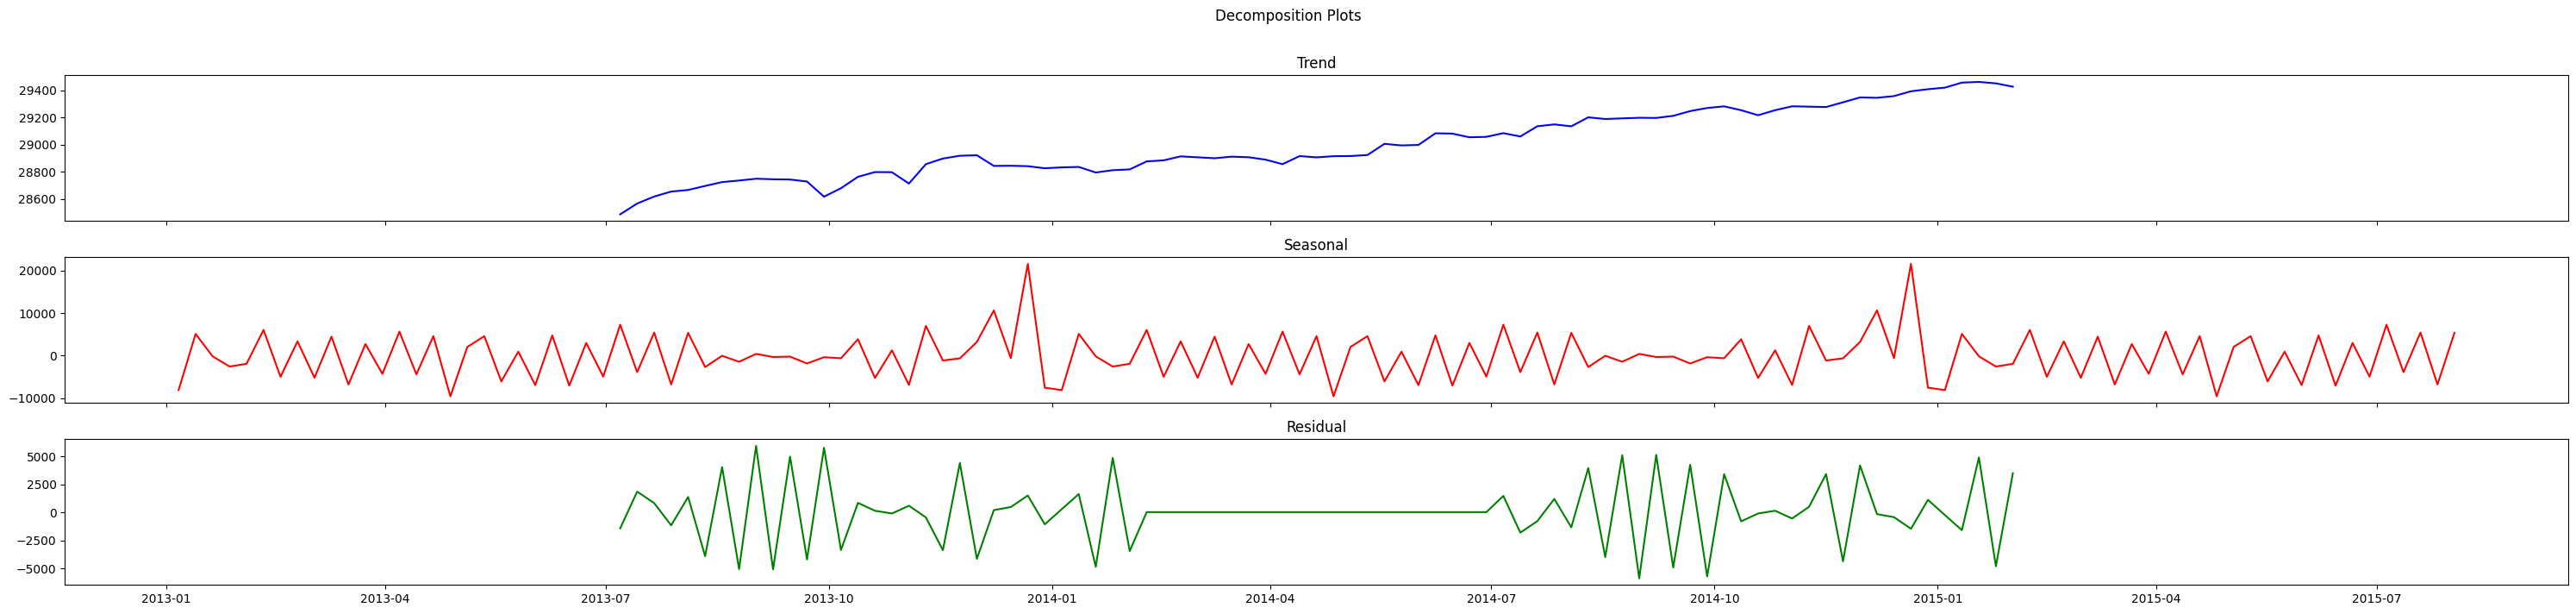

In [7]:
plot_timeseries(weekly_features["Sales"])

- The **trend** shows a small variation in data (~200). It has a We'll check if this affect our approach in a moment.
- The **seasonal** component is strong (variation of ~4000), but with irregularities and peaks that may be related to holidays. Our future prediction model must take this in consideration.
- The strong **residual** component (variation of ~2000) indicates that the behavior of series is too random, and we may have difficulties in finding a satisfactory forecasting model.

### Check for Stationarity

The visual inspection via rolling statistics approach provides an accessible and intuitive means to visually inspect the temporal stability of a time series. A consistent mean and standard deviation over the rolling window support the assumption of stationarity, whereas notable variations signal potential non-stationary behavior. This method serves as an initial diagnostic tool to guide further exploration and analysis of time series properties.

By incorporating both visual methods and statistical tests like ADF and KPSS, you establish a robust framework for evaluating the stationarity of a time series, supporting more informed decisions in subsequent analysis and modeling efforts.

In [8]:
def test_stationarity(series: pd.DataFrame, confidence: float = 0.05) -> None:
    roll_mean = series.rolling(window=3).mean()
    roll_std = series.rolling(window=3).std()
    
    fig, ax = plt.subplots(figsize=(30, 3))
    fig.suptitle("Time series rolling statistics")
    
    ax.plot(series, color="blue", label="original")
    ax.plot(roll_mean, color="red", label="Rolling Mean")
    ax.plot(roll_std, color="green", label="Rolling STD")
    ax.legend(loc="best")
    plt.show()
    
    adfuller_results = adfuller(series, autolag="AIC")
    records1 = {
        k: v for k, v in zip(
            ("Test Statistic", "p-value", "# Lags Used"),
            adfuller_results[:3]
        )
    }
    for key, value in adfuller_results[4].items():
        records1[f"Critical Value ({key})"] = value
    
    kpss_results = kpss(series, nlags="auto")
    records2 = {
        k: v for k, v in zip(
            ("Test Statistic", "p-value", "# Lags Used"),
            kpss_results[:3]
        )
    }
    for key, value in kpss_results[3].items():
        records2[f"Critical Value ({key})"] = value
    
    results_df = pd.DataFrame.from_records((records1, records2), index=[
        "ADF", "KPSS"
    ])
    display(results_df.T)
    
    adf_stationarity = records1["p-value"] < confidence
    kpss_stationarity = records2["p-value"] > confidence
    
    print(f"ADF stationarity: {adf_stationarity} -- KPSS stationarity: {kpss_stationarity}")

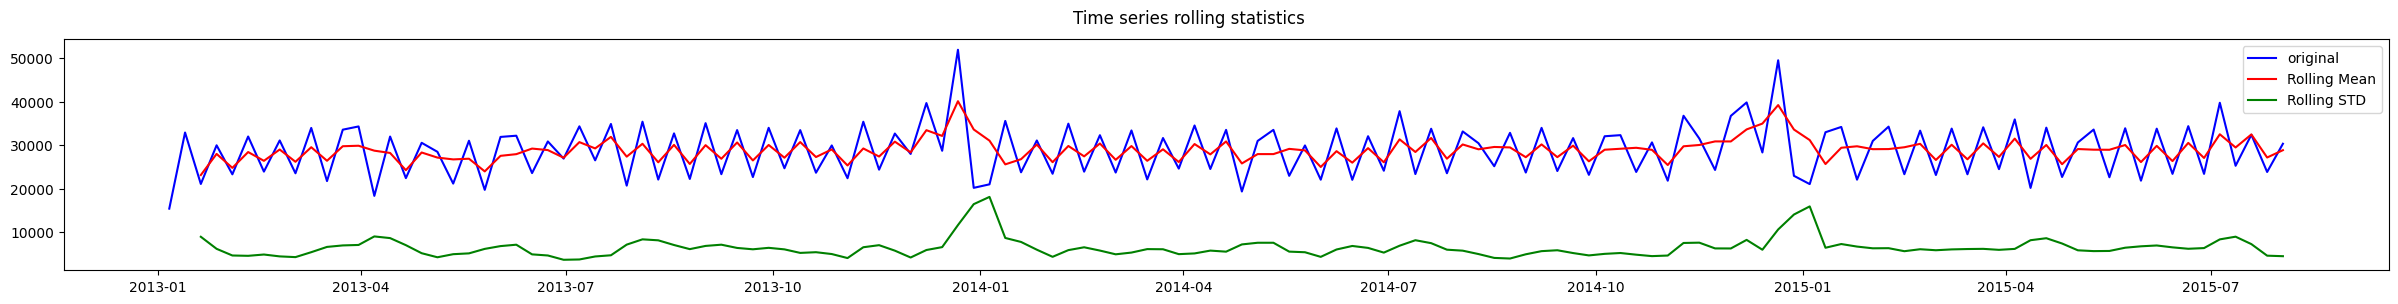

,ADF,KPSS
Test Statistic,-8.876472e+00,0.322297
p-value,1.353722e-14,0.100000
# Lags Used,1.000000e+00,4.000000
Critical Value (1%),-3.480500e+00,0.739000
Critical Value (5%),-2.883528e+00,0.463000
Critical Value (10%),-2.578496e+00,0.347000
Critical Value (2.5%),NaN,0.574000


ADF stationarity: True -- KPSS stationarity: True


In [9]:
test_stationarity(weekly_features["Sales"])

By visual inspection, we can conclude that, despite the pontual fluctuations, we don't have a trend in the mean and variance of the data, which my indicate stationarity.

The quantitative tests are summarize into a table. these are the most important ones:
- Test Statistic: Measures how far the observed data deviates from the null hypothesis.
    - For ADF test, a low value indicates a rejection of the null hypothesis, supporting stationarity.
    - For KPSS test, a high value suggests stronger evidence against the null hypothesis of stationarity.
- p-value: The p-value associated with the hypothesis tests.
    - For ADF test, a low value indicates strong evidence against the null hypothesis of non-stationarity. This supports the conclusion of stationarity.
    - For KPSS test, a high value suggests stronger evidence against the null hypothesis of stationarity.

The tests results are:
- The p-value lower than 0.05 for the ADF test indicates that we can reject the nul-hypothesis of the data is non-stationary.
- The p-value higher than 0.05 for the KPSS test indicates that we cannot reject the null hypothesis that the data is stationary around a deterministc trend.

With this, we can safetly assume the data as **trend stationary**.

# SARIMAX forecasting model

## The ARIMA Model Family

The ARIMA (AutoRegressive Integrated Moving Average) model family comprises a set of time series forecasting models recognized for their effectiveness in capturing and predicting temporal patterns.

The general equation of the AutoRegressive Integrated Moving Average (ARIMA) model is expressed as follows:

$$
Y_t' = c + \sum_i^p \phi_i Y_{t-i}' + \sum_j^q \theta_j \epsilon_{t-j} + \epsilon_t,
$$

where:
- $Y_t'$ is the differenced time series at time 't'.
- $c$ is a constant term.
- $\phi_1$, $\phi_2$, $\ldots$, $\phi_p$ are the autoregressive parameters.
- $Y_{t-1}'$, $Y_{t-2}'$, $\ldots$, $Y_{t-p}'$ are the lagged differenced values.
- $\theta_1$, $\theta_2$, $\ldots$, $\theta_q$ are the moving average parameters.
- $\epsilon_{t-1}$, $\epsilon_{t-2}$, $\ldots$, $\epsilon_{t-q}$ are the white noise error terms.
- $\epsilon_t$ is the current error term.

The model's order is denoted as ARIMA(p, d, q), where 'p' is the order of the autoregressive component, 'd' is the degree of differencing, and 'q' is the order of the moving average component. The ARIMA model provides a flexible and widely applicable framework for modeling and forecasting time series data.

 The models consist of three fundamental components:

- **AutoRegressive (AR) Component (p):** Captures the relationship between the current observation and its past values, signifying the influence of historical data points on the present.

- **Integrated (I) Component (d):** Encompasses differencing the time series to attain stationarity. The degree of differencing (d) is determined based on the transformations needed to make the series stationary by removing trends or seasonality.

- **Moving Average (MA) Component (q):** Incorporates the weighted sum of past forecast errors, elucidating the impact of historical shocks on the current observation.

Together, these components construct the ARIMA model, denoted as ARIMA(p, d, q). This parameterized configuration (p, d, q) enables the ARIMA model to flexibly adapt to diverse time series patterns, providing a robust foundation for time series analysis and forecasting.

ARIMA models provide a versatile framework for analyzing and forecasting time-dependent data by incorporating past observations, addressing non-stationarity through differencing, and considering the weighted sum of past forecast errors.

ARIMA is effective for capturing non-seasonal temporal patterns but lacks explicit components to model seasonality. The SARIMA (Seasonal AutoRegressive Integrated Moving Average) model extends the ARIMA framework by incorporating seasonal components, making it more suitable for datasets with pronounced recurring patterns at fixed intervals. SARIMA explicitly addresses seasonality, providing a more accurate representation of time series data with periodic trends.

The updated equation for the SARIMA model is:

$$
Y_t' = c + \sum_{i=1}^p \phi_i Y_{t-i}' + \sum_{j=1}^q \theta_j \epsilon_{t-j} + \sum_{k=1}^P \phi_k Y_{t-ks} + \sum_{l=1}^Q \theta_l \epsilon_{l-ms} + \epsilon_t,
$$

where:
- $\phi_1 Y_{t-s} + \phi_2 Y_{t-2s} + \ldots + \phi_P Y_{t-Ps}$ represents the seasonal autoregressive component.
- $\theta_1 \epsilon_{t-s} + \theta_2 \epsilon_{t-2s} + \ldots + \theta_Q \epsilon_{t-Qs}$ represents the seasonal moving average component.
- $s$ represents the seasonal period, the interval at which the seasonal patterns repeat in the time series data.

The SARIMA model encompasses additional components beyond the basic ARIMA framework to explicitly address seasonality in time series data:

- **Seasonal AutoRegressive (SAR) Component:** Denoted as SAR(p), where 'p' is the order of the seasonal autoregressive component, represents the correlation between the current observation and its past values at seasonal intervals.


- **Seasonal Integrated (SI) Component:** Denoted as SI(d), where 'd' is the degree of seasonal differencing, involves differencing the time series data at seasonal intervals to achieve stationarity.


- **Seasonal Moving Average (SMA) Component:** Denoted as SMA(q), where 'q' is the order of the seasonal moving average component, incorporates the weighted sum of past forecast errors at seasonal intervals.

These seasonal components, when combined with the corresponding non-seasonal ARIMA components, complete the SARIMA model, denoted as SARIMA(p, d, q) × (P, D, Q, s).

SARIMA is effective in modeling time series with inherent seasonal patterns. However, its limitations become apparent when external factors not accounted for in the time series significantly influence its behavior. This is where SARIMAX comes in.

The Seasonal AutoRegressive Integrated Moving Average with eXogenous factors (SARIMAX) model is an extension of SARIMA that addresses this limitation by introducing the capability to include exogenous variables. The general form of the SARIMAX model is as follows:


$$Y_t = c + \sum_{i=1}^{p} \phi_i Y_{t-i} + \sum_{j=1}^{q} \theta_j \epsilon_{t-j} + \sum_{k=1}^{P} \phi_k Y_{t-ks} + \sum_{l=1}^{Q} \theta_l \epsilon_{t-ls} + \sum_{m=1}^{k} X_{m,t} \beta_m + \epsilon_t,
$$

where:
- $ \beta_1 X_{1,t} + \beta_2 X_{2,t} + \beta_3 X_{3,t} + \ldots + \beta_m X_{m,t} $ represents the exogenous variables component at time 't'.

This extension enhances forecasting capabilities, allowing for a more comprehensive approach that considers both inherent seasonality and the influence of external factors on the time series.

## Dataset Split

Let's proceed to prepare our data for training. We'll collect the 20% more recent data for validation and the reamaining will be used for training.

In [10]:
data_len = len(weekly_features.index)
test_len = int(data_len * 0.2)

train_df = weekly_features.iloc[:-test_len]
test_df = weekly_features.iloc[-test_len:]

display(train_df)
display(test_df)

,Sales,StateHoliday,Promo
Date,,,
2013-01-06,15407,1,0
2013-01-13,32914,0,1
2013-01-20,21081,0,0
2013-01-27,29973,0,1
2013-02-03,23297,0,0
...,...,...,...
2014-12-28,22955,1,0
2015-01-04,21050,0,0
2015-01-11,32981,0,1


,Sales,StateHoliday,Promo
Date,,,
2015-02-01,30982,0,1
2015-02-08,34267,0,1
2015-02-15,23325,0,0
2015-02-22,33343,0,1
2015-03-01,23143,0,0
2015-03-08,33815,0,1
2015-03-15,23309,0,0
2015-03-22,34118,0,1
2015-03-29,24492,0,0


## ACF and PACF Analysis

To determine the appropriate parameters (p, q, d, P, Q, D) for our SARIMAX model, we will leverage the AutoCorrelation Function (ACF) and Partial AutoCorrelation Function (PACF) plots.

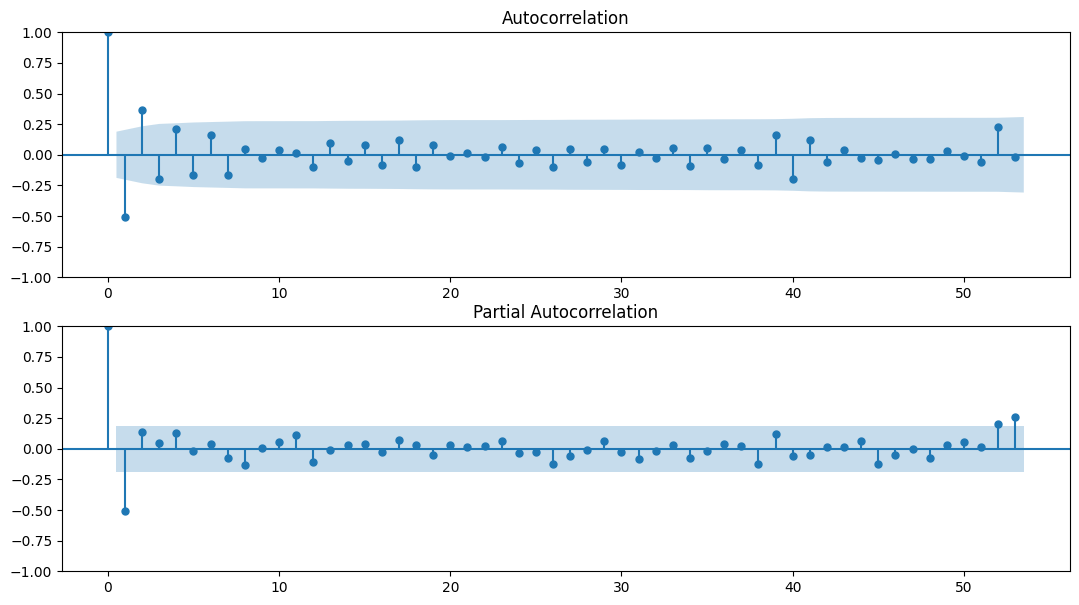

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(13, 7))

sm.graphics.tsaplots.plot_acf(train_df["Sales"], lags=53, ax=ax1)
sm.graphics.tsaplots.plot_pacf(train_df["Sales"], lags=53, ax=ax2)

plt.show()

- There's a gradual decline in the ACF plot, suggesting that differencing is needed.
- Also in the ACF, there's a peak at lag 52, followed by a abrupt decline in lag 53, indicating seasonality with seasonal order of 52.
- We can identify that lags 1 and 2 in ACF are significant lags before crossing the significance threshold (blue zone). This suggests q = 2 and Q = 0.
- In the PACF plot, there's a abrupt decline after lag 1, indicating that p = 1
- The presence of a peak in PACF near the lag of seasonal order indicates a P = 1.

We can use these values as initial shot for the SARIMAX parameters.

## Model Training

We will utilize the `auto_arima` function from the **pmdarima** package to automate the process of selecting optimal parameters for our SARIMAX model. This function systematically explores potential values for autoregressive (p), differencing (d), moving average (q), seasonal autoregressive (P), seasonal differencing (D), and seasonal moving average (Q) orders. For each parameter combination, the SARIMAX model is fitted to the data. AIC or BIC values are computed for each model, serving as information criteria to assess the trade-off between model fit and complexity. The model with the lowest AIC or BIC value is considered optimal, striking a balance between accuracy and simplicity. The SARIMAX model with the identified optimal parameters is then fitted to the entire dataset for final forecasting.

We'll use the values obtained by analyzing the ACF and PACF plots are used as an initial guess. Additionally, the Sales series is transformed using Scikit-Learn's MinMaxScaler. This normalization process is applied to scale the values within a specific range, typically [0, 1]. Normalizing the series can be beneficial, particularly when working with models sensitive to the scale of input features. MinMaxScaler ensures that the data conforms to a consistent scale, preventing any single feature from dominating the modeling process due to differences in magnitude.

In [12]:
scaler = MinMaxScaler()
sales = scaler.fit_transform(train_df["Sales"].to_frame())

In [19]:
auto_arima_results = auto_arima(
    sales,
    start_p=0,
    start_q=0,
    d=0,
    max_p=2,
    max_q=3,
    max_d=2,
    start_P=1,
    start_Q=1,
    D=0,
    max_P=2,
    max_Q=2,
    max_D=2,
    max_order=5,
    m=52,
    seasonal=True,
    exogenous=train_df[["StateHoliday", "Promo"]],
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True
)

auto_arima_results.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[52] intercept   : AIC=-78.400, Time=1.80 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=-69.955, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=inf, Time=2.09 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=inf, Time=1.44 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=112.015, Time=0.01 sec
 ARIMA(0,0,0)(0,0,1)[52] intercept   : AIC=-80.115, Time=0.46 sec
 ARIMA(0,0,0)(0,0,2)[52] intercept   : AIC=-78.400, Time=5.06 sec
 ARIMA(0,0,0)(1,0,0)[52] intercept   : AIC=-80.400, Time=1.37 sec
 ARIMA(0,0,0)(2,0,0)[52] intercept   : AIC=-78.400, Time=2.03 sec
 ARIMA(0,0,0)(2,0,1)[52] intercept   : AIC=-76.400, Time=4.84 sec
 ARIMA(0,0,1)(1,0,0)[52] intercept   : AIC=-110.386, Time=1.77 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=-90.082, Time=0.03 sec
 ARIMA(0,0,1)(2,0,0)[52] intercept   : AIC=-108.420, Time=9.85 sec
 ARIMA(0,0,1)(1,0,1)[52] intercept   : AIC=-108.420, Time=2.26 sec
 ARIMA(0,0,1)(2,0,1)[52] intercept   :

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  108
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 52)   Log Likelihood                  69.403
Date:                             Fri, 17 Nov 2023   AIC                           -128.806
Time:                                     13:38:11   BIC                           -115.395
Sample:                                          0   HQIC                          -123.368
                                             - 108                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2086      0.043      4.827      0.000       0.124       0.293
ar.L1         -0.6962      0.094     -7.426      0.000      -0.880      -0.512
ma.L1          0.0753      0.142      0.529      0.597      -0.204       0.354
ar.S.L52       0.6643      0.063     10.608      0.000       0.542       0.787
sigma2         0.0122      0.002      8.087      0.000       0.009       0.015
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                96.63
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                             1.35
Prob(H) (two-sided):                  0.31   Kurtosis:                         6.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The final SARIMAX model is trained using the identified optimal values. This model is then fitted to the entire dataset for comprehensive forecasting.

To assess the performance of the trained SARIMAX model, the `plot_diagnostics` function is employed. This function, commonly available in time series modeling libraries, generates a set of diagnostic plots to evaluate the model's assumptions and identify potential issues.

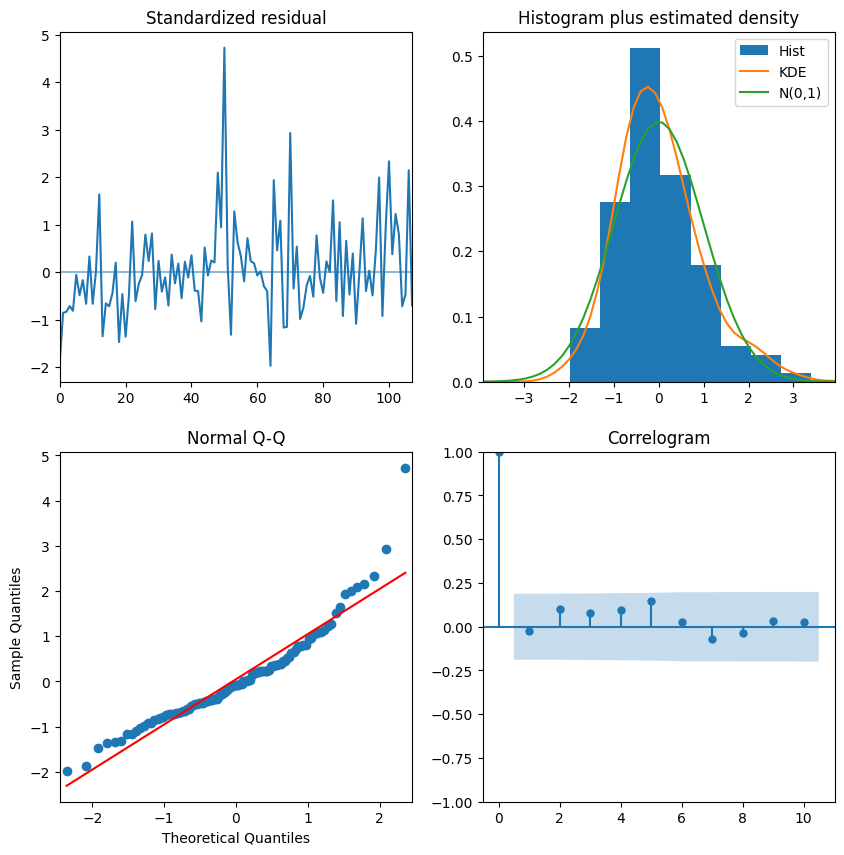

In [14]:
auto_arima_results = auto_arima_results.fit(sales)

auto_arima_results.plot_diagnostics(figsize=(10, 10))
plt.show()

This is how we these plots can be interpreted:

1. **Residuals Plot:**

- Examines the residuals for randomness and independence. Ideally, residuals should exhibit no discernible patterns, as in our case.

2. **Kernel Density Estimate (KDE) of Residuals:**

- Provides a visual representation of the distribution of residuals. The more the distribution resembles a normal distribution, the better.

3. **Quantile-Quantile (Q-Q) Plot:**

- Compares the distribution of residuals against the expected distribution (normal distribution). The straight line in the Q-Q plot suggests normality.

4. **Correlogram of Residuals:**

- Displays the autocorrelation of residuals at different lags. As there aren't amu significant spikes in the correlogram, we can safelly assume that aren't remaining patterns in the residuals.

In other words, our model isn't perfect, but it did just fine.

## Visualizing the model's performance

To visually assess the performance of the trained SARIMA model, we will generate a plot showcasing the fitted values alongside the original training and test values of the time series. This comparison allows for a direct visualization of how well the model captures the patterns and dynamics present in the historical training data.

It's important to note that we'll need to use the inverse transform of the MinMaxScaler on the fitted values. This step is necessary to bring the scaled values back to their original scale, ensuring that the visual representation aligns with the original values of the time series. 

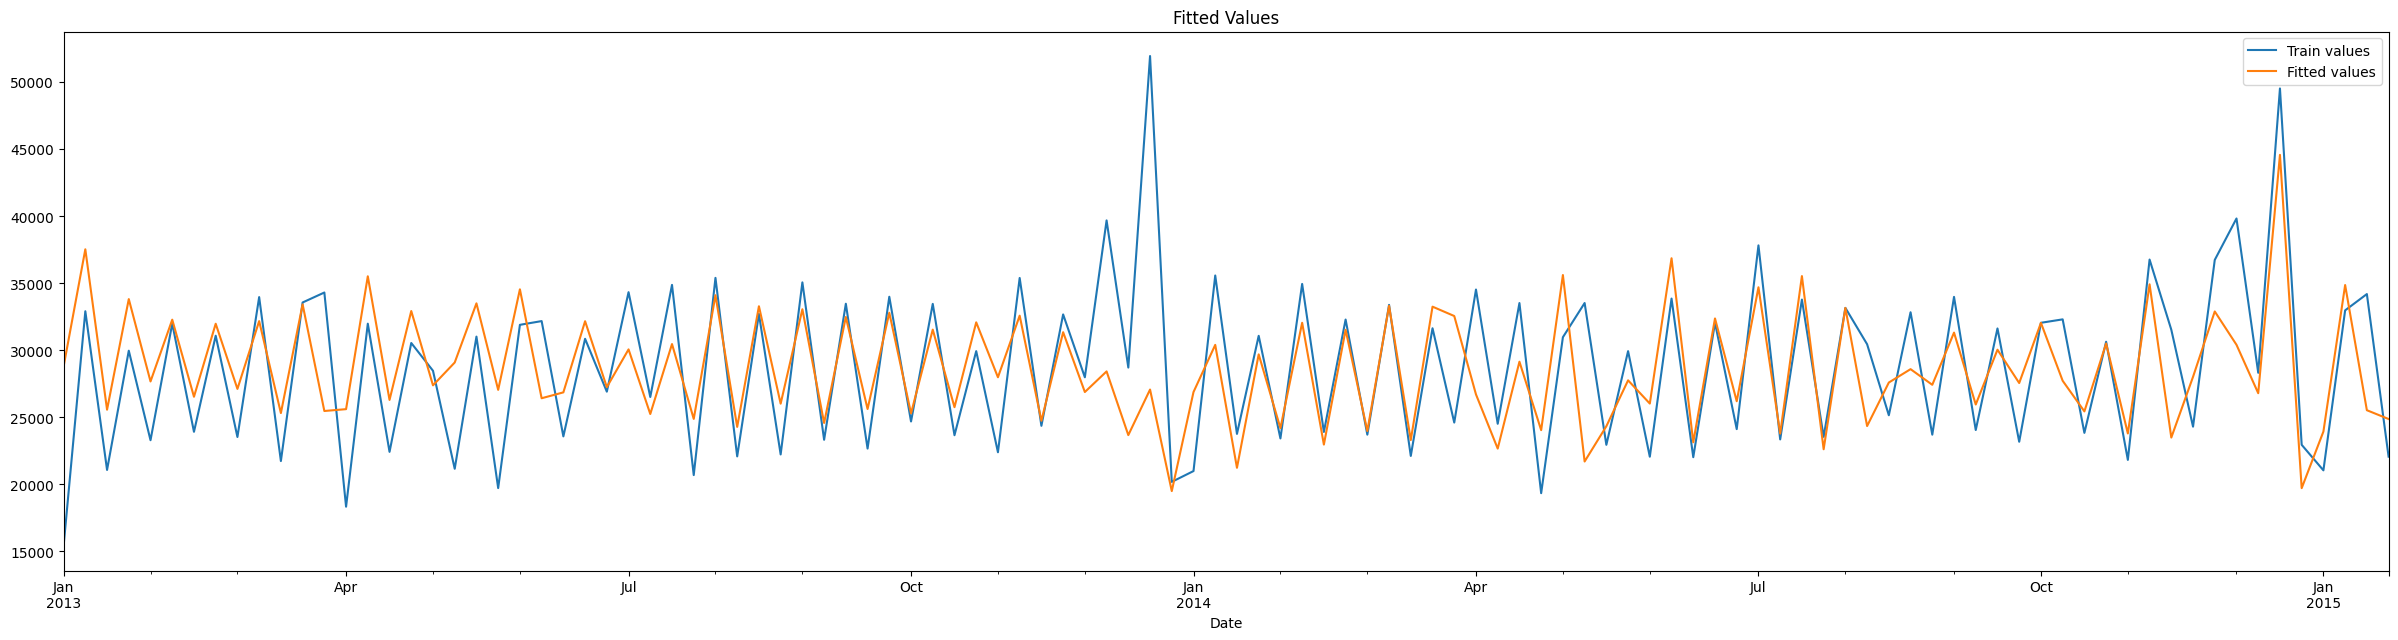

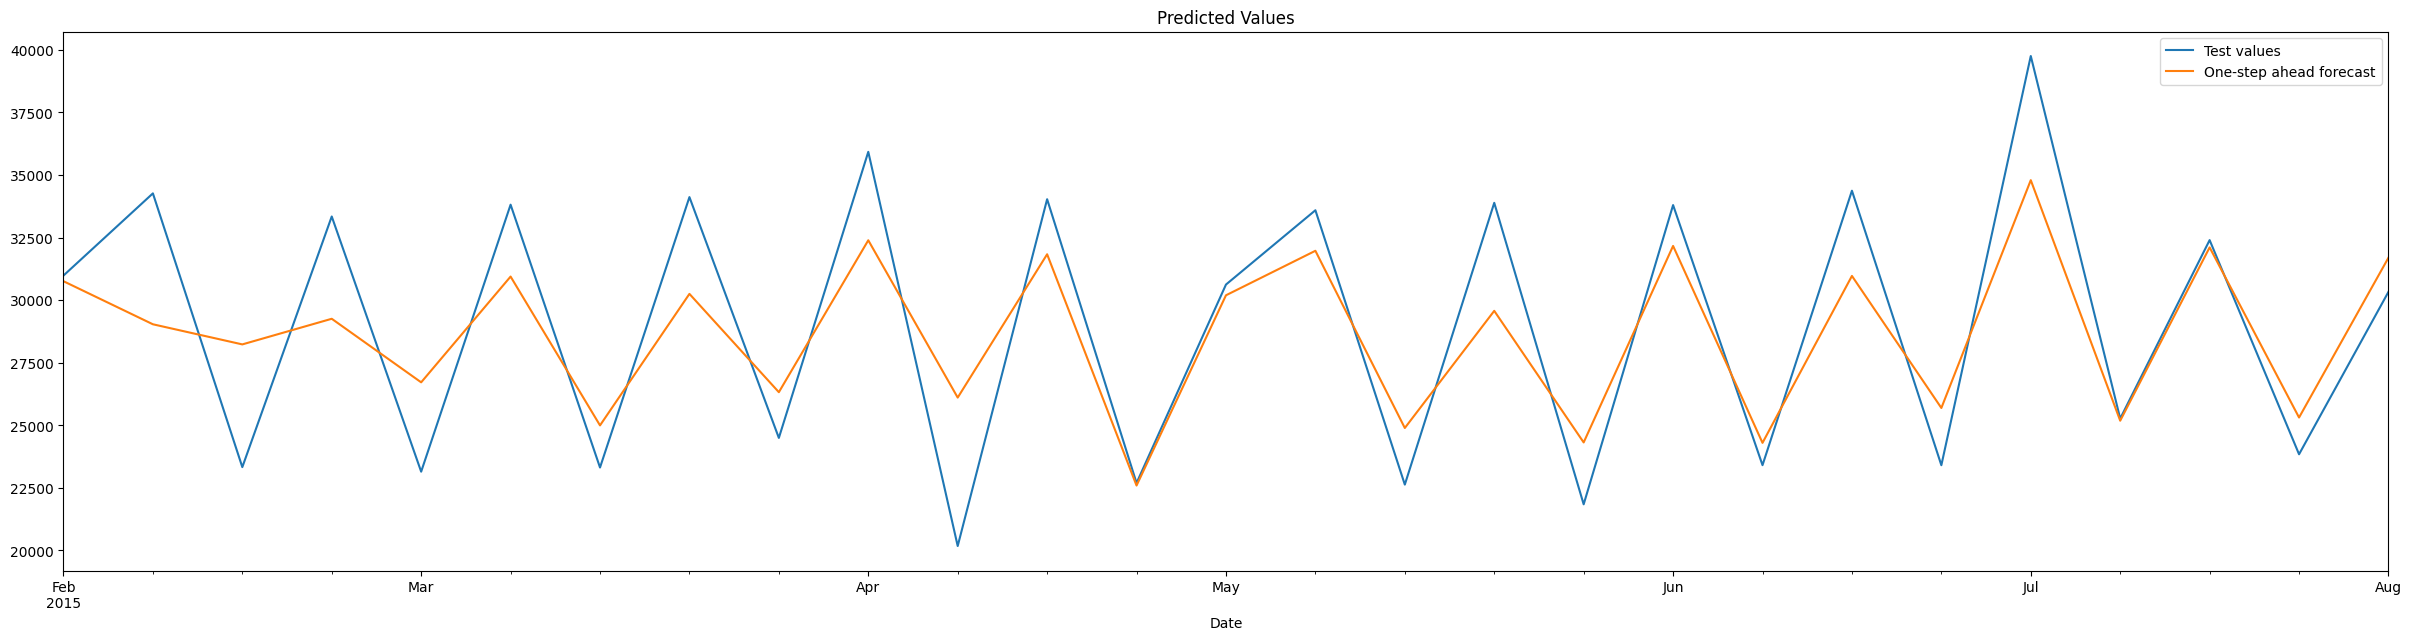

In [15]:
train_preds = auto_arima_results.fittedvalues()
train_preds = pd.Series(scaler.inverse_transform(train_preds[np.newaxis, :])[0]).to_frame("Fitted values")
train_preds = train_preds.set_index(train_df.index)
test_preds = auto_arima_results.predict(n_periods=len(test_df))
test_preds = pd.Series(scaler.inverse_transform(test_preds[np.newaxis, :])[0]).to_frame("One-step ahead forecast")
test_preds = test_preds.set_index(test_df.index)

plt.figure()
plt.title("Fitted Values")
ax1 = train_df["Sales"].plot(label="Train values", kind="line", figsize=(30, 7))
train_preds.plot(label="Fitted values", kind="line", ax=ax1)
plt.legend();

plt.figure()
plt.title("Predicted Values")
ax2 = test_df["Sales"].plot(label="Test values", kind="line", figsize=(30, 7))
test_preds.plot(label="One-step ahead forecast", kind="line", ax=ax2)
plt.legend();

The fitted series generally aligns with the training patterns; however, specific discrepancies exist. For instance, there is a substantial sales peak observed in November 2014 that the model failed to accurately capture. In contrast, a similar sales peak occurring in November 2015 was successfully reflected in the fitted series.

Such discrepancies between observed peaks and the model's ability to capture them are not uncommon in time series forecasting. They may stem from various factors, including the complexity of the underlying data patterns, the influence of unaccounted external factors, or the model's inherent limitations in precisely forecasting rare or anomalous events. These instances highlight the inherent challenge in forecasting real-world time series data, where unexpected or irregular occurrences may impact the model's predictive accuracy selectively.

Now we'll visualize the residuals: the differences between the fitted or forecasted values and the actual observed values in the time series data. Examining these residuals allows us to understand the pattern of errors made by the model.

In [16]:
train_preds

,Fitted values
Date,
2013-01-06,28790.984501
2013-01-13,37532.220463
2013-01-20,25573.956508
2013-01-27,33820.268761
2013-02-03,27678.559466
...,...
2014-12-28,19722.503025
2015-01-04,23942.193753
2015-01-11,34867.807914


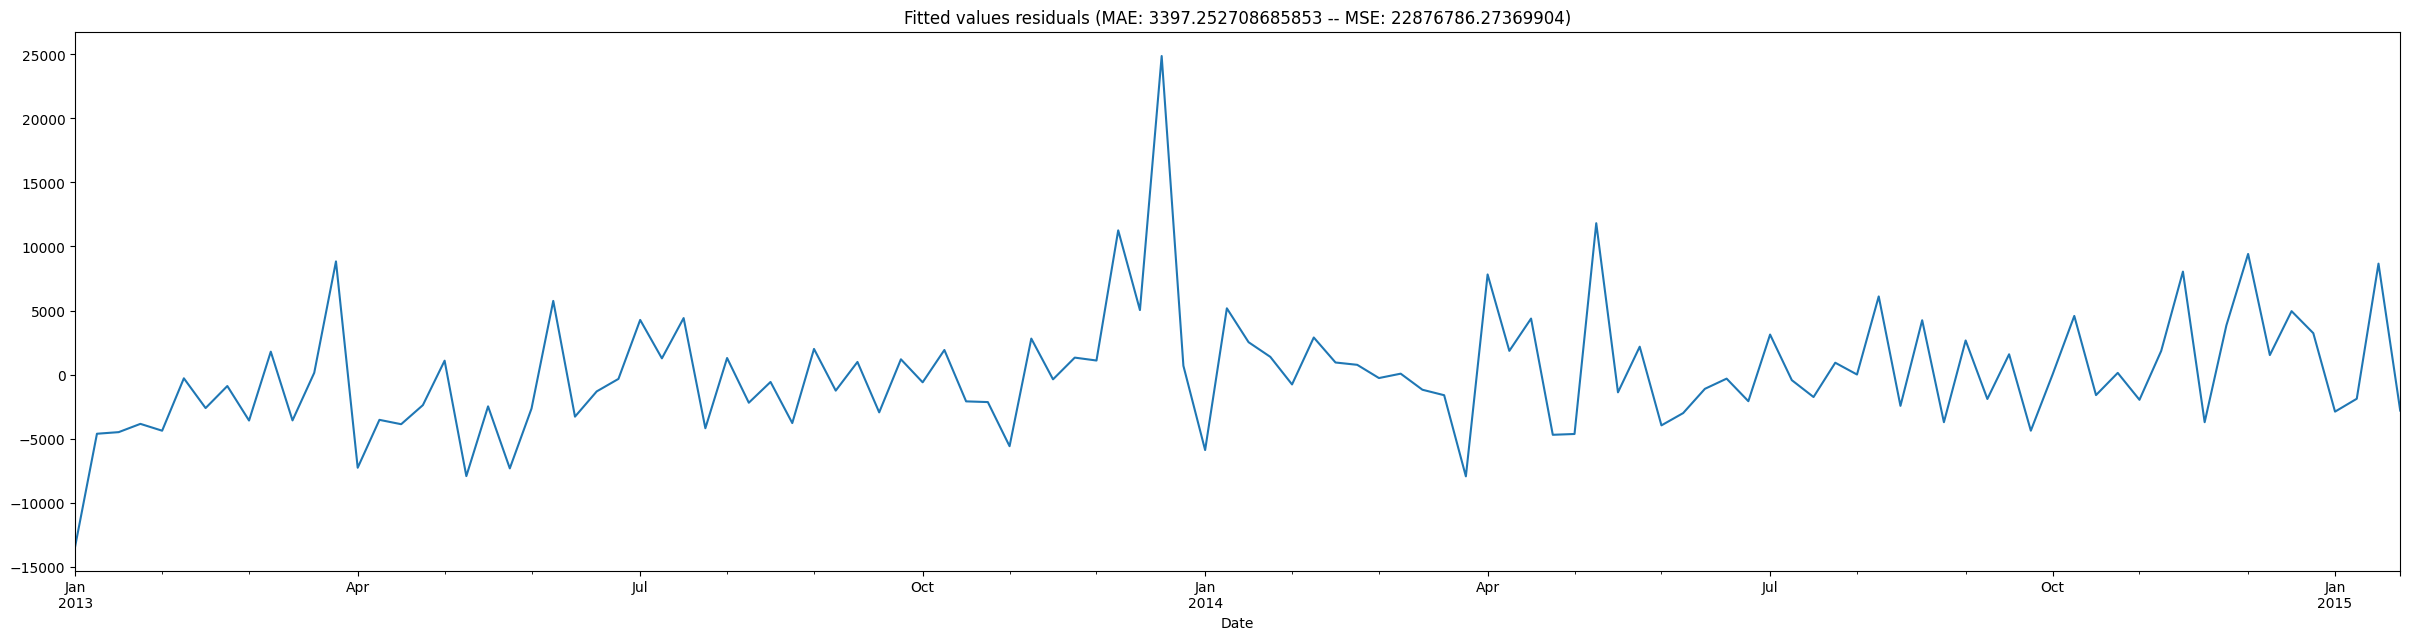

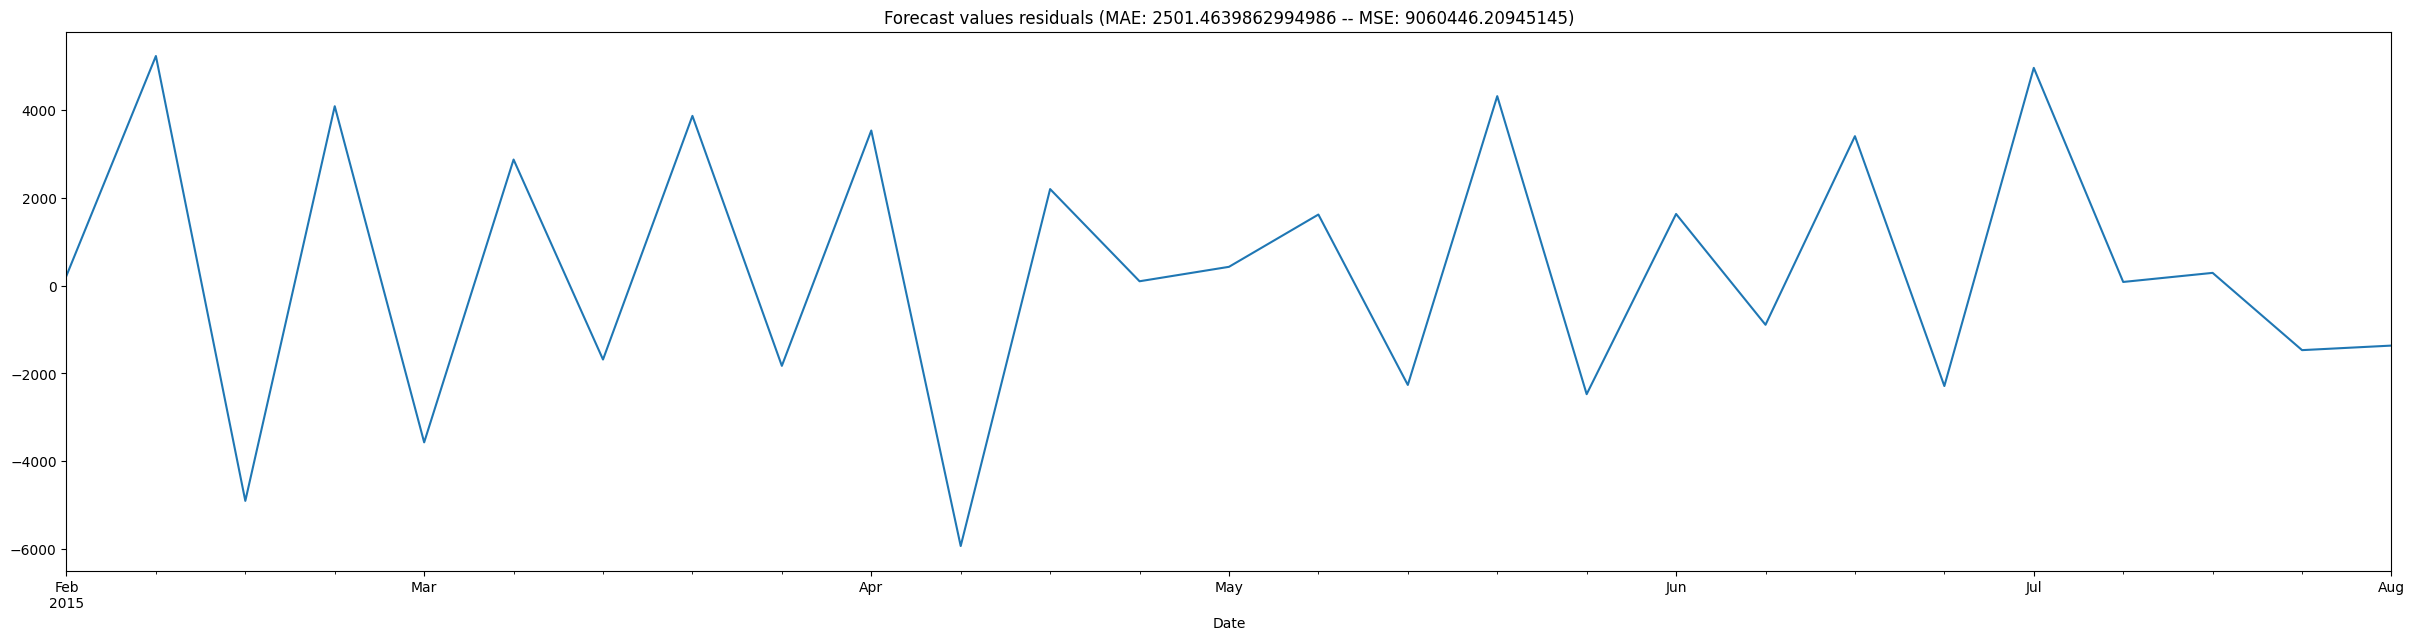

In [17]:
train_residuals = train_df["Sales"] - train_preds["Fitted values"]
train_mae = mean_absolute_error(train_df["Sales"], train_preds["Fitted values"])
train_mse = mean_squared_error(train_df["Sales"], train_preds["Fitted values"])

test_residuals = test_df["Sales"] - test_preds["One-step ahead forecast"]
test_mae = mean_absolute_error(test_df["Sales"], test_preds["One-step ahead forecast"])
test_mse = mean_squared_error(test_df["Sales"], test_preds["One-step ahead forecast"])

plt.figure()
plt.title(f"Fitted values residuals (MAE: {train_mae} -- MSE: {train_mse})")
train_residuals.plot(label="Fitted values residuals", kind="line", figsize=(30, 7));

plt.figure()
plt.title(f"Forecast values residuals (MAE: {test_mae} -- MSE: {test_mse})")
test_residuals.plot(label="Forecast values residuals", kind="line", figsize=(30, 7));

The Mean Absolute Error (MAE) and Mean Squared Error (MSE) of the forecasted values are lower than those of the fitted values. This discrepancy might be attributed to the absence of sales peaks in the test set, specifically lacking data points corresponding to the year-end periods. As a result, the model's performance metrics could reflect lower errors due to the absence of specific patterns or events present in the training data but absent in the test data.